In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from datetime import datetime
from tqdm.notebook import tqdm_notebook

In [2]:
# Setting the seed
random.seed(42)
g = torch.Generator().manual_seed(2147483647)

In [3]:
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


In [4]:
# set the preprocess operations to be performed on train/val/test samples
MNIST_preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize((0.5,), (0.5,))])

# download MNIST training set and reserve 50000 for training
train_dataset = torchvision.datasets.MNIST(root='C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/train', train=True, download=True, transform=MNIST_preprocess)
train_set, _ = torch.utils.data.random_split(train_dataset, [50000, 10000])

# download MNIST training set and reserve 10000 for validation
val_dataset = torchvision.datasets.MNIST(root='C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/train', train=True, download=False, transform=MNIST_preprocess)
_, val_set = torch.utils.data.random_split(val_dataset, [50000, 10000])

# download MNIST test set
test_set = torchvision.datasets.MNIST(root='C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/test', train=False, download=True, transform=MNIST_preprocess)


100%|██████████| 9912422/9912422 [00:00<00:00, 97640719.40it/s]


Extracting C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/train/MNIST/raw/train-images-idx3-ubyte.gz to C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/train/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34869226.78it/s]


Extracting C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/train/MNIST/raw/train-labels-idx1-ubyte.gz to C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29806921.71it/s]


Extracting C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/train/MNIST/raw/t10k-images-idx3-ubyte.gz to C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/train/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16755082.47it/s]


Extracting C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/train/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 114813874.21it/s]

Extracting C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/test/MNIST/raw/train-images-idx3-ubyte.gz to C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/test/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 92118398.35it/s]


Extracting C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/test/MNIST/raw/train-labels-idx1-ubyte.gz to C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/test/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27605263.27it/s]


Extracting C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/test/MNIST/raw/t10k-images-idx3-ubyte.gz to C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/test/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16352385.21it/s]

Extracting C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to C:/Users/hp/OneDrive/Bureaublad/archive (1)/MNIST/raw/test/MNIST/raw



In [5]:
# Define data loaders using the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)

# Verify the size of each dataloader
print(len(train_loader.dataset))
print(len(val_loader.dataset))
print(len(test_loader.dataset))


50000
10000
10000


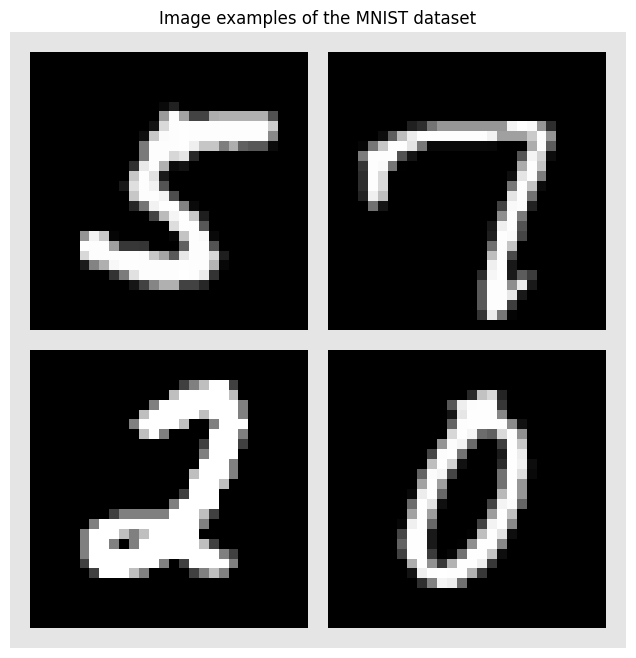

In [6]:
import matplotlib.pyplot as plt
# Visualize some examples
NUM_IMAGES = 4
MNIST_examples = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_examples, nrow=2, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [12]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of an image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x


In [13]:
# Define the Vision Transformer (VIT) model
#définit le modèle Vision Transformer (VIT) avec une attention multi-têtes.
# Ce modèle est conçu pour fonctionner avec des images de la base de données MNIST.
# La classe AttentionBlock définit un bloc d'attention multi-têtes, et la classe VisionTransformer
# assemble ces blocs pour construire le modèle complet. Le modèle prend en compte la position
# des patches et utilise une tête de classification MLP pour produire la sortie finale.
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:, : T + 1]

        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [14]:
# Create an instance of the VisionTransformer model
model = VisionTransformer(
    embed_dim=256,
    hidden_dim=256 * 3,
    num_heads=8,
    num_layers=6,
    patch_size=7,
    num_channels=1,
    num_patches=16,
    num_classes=10,
    dropout=0.2
)

# Transfer the model to GPU if available
model.to(device)

VisionTransformer(
  (input_layer): Linear(in_features=49, out_features=256, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=768, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): Layer

In [15]:
# Restore the model from a saved checkpoint if available
model_restore = None  # '/content/model_20230712_211204_0'
if model_restore is not None and os.path.exists(model_restore):
    model.load_state_dict(torch.load(model_restore))
    model.restored = True

# Define the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
model_optimizer = optim.Adam(model.parameters(), lr=3e-4)
model_scheduler = optim.lr_scheduler.MultiStepLR(model_optimizer, milestones=[100, 150], gamma=0.1)


In [16]:

# Lists to track the training loss and the best validation loss
losses = []
best_validation_loss = 1_000_000

# Training loop
for epoch in range(20):
    for imgs, labels in tqdm_notebook(train_loader, desc='epoch ' + str(epoch)):
        model.train(True)
        imgs, labels = imgs.to(device), labels.to(device)
        model_optimizer.zero_grad()
        preds = model(imgs)
        loss = loss_fn(preds, labels)
        losses.append(loss.item())
        loss.backward()
        model_optimizer.step()

    # Step the scheduler for learning rate decay
    model_scheduler.step()

    # Validation
    running_validation_loss = 0.0
    model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_validation_loss += vloss

    avg_validation_loss = running_validation_loss / (i + 1)

    print('Epoch {}: Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch, loss.item(), avg_validation_loss.item()))

    # Track best performance and save the model's state
    if avg_validation_loss < best_validation_loss:
        best_validation_loss = avg_validation_loss
        model_path = '/model_VisionTransformer_MNIST_{}.pt'.format(epoch + 1)
        torch.save(model.state_dict(), model_path)


epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 0: Training Loss: 0.0358, Validation Loss: 0.1297


epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: Training Loss: 0.6005, Validation Loss: 0.0873


epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: Training Loss: 0.0162, Validation Loss: 0.0774


epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: Training Loss: 0.0201, Validation Loss: 0.0690


epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4: Training Loss: 0.1816, Validation Loss: 0.0636


epoch 5:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5: Training Loss: 0.0554, Validation Loss: 0.0572


epoch 6:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6: Training Loss: 0.0226, Validation Loss: 0.0483


epoch 7:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7: Training Loss: 0.1333, Validation Loss: 0.0488


epoch 8:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8: Training Loss: 0.0591, Validation Loss: 0.0475


epoch 9:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9: Training Loss: 0.2876, Validation Loss: 0.0476


epoch 10:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10: Training Loss: 0.0901, Validation Loss: 0.0349


epoch 11:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11: Training Loss: 0.0040, Validation Loss: 0.0425


epoch 12:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12: Training Loss: 0.1721, Validation Loss: 0.0305


epoch 13:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13: Training Loss: 0.0022, Validation Loss: 0.0358


epoch 14:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14: Training Loss: 0.0018, Validation Loss: 0.0347


epoch 15:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15: Training Loss: 0.0138, Validation Loss: 0.0484


epoch 16:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 16: Training Loss: 0.0080, Validation Loss: 0.0288


epoch 17:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 17: Training Loss: 0.1239, Validation Loss: 0.0345


epoch 18:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 18: Training Loss: 0.1180, Validation Loss: 0.0378


epoch 19:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 19: Training Loss: 0.0003, Validation Loss: 0.0363


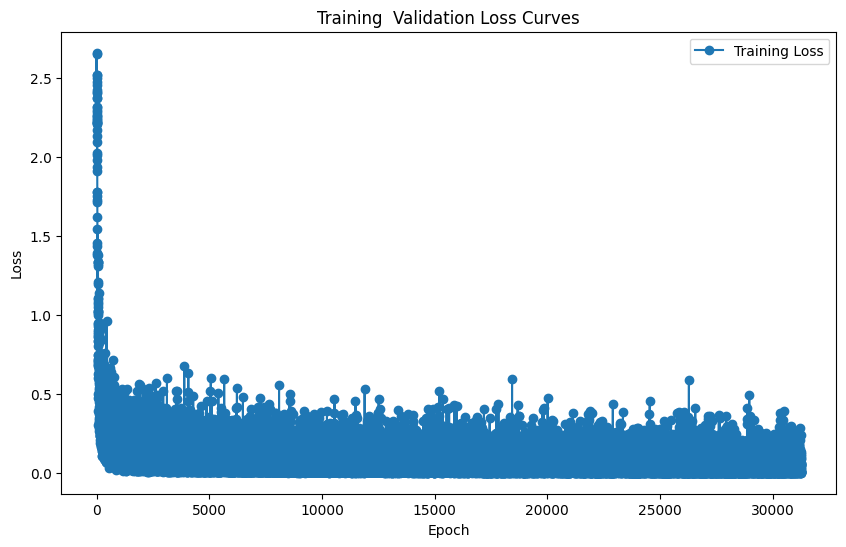

In [20]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training  Validation Loss Curves')
plt.legend()
plt.show()


In [21]:
from sklearn.metrics import accuracy_score, f1_score
import time

# Charger le modèle à partir du dernier checkpoint
if model_restore is not None and os.path.exists(model_restore):
    model.load_state_dict(torch.load(model_restore))
    model.restored = True

# Mettre le modèle en mode évaluation
model.eval()

# Liste pour stocker les prédictions et les étiquettes réelles
all_labels = []
all_predictions = []

# Mesurer le temps d'inférence
start_time = time.time()

# Désactiver le suivi des gradients et réduire la consommation de mémoire
with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        test_inputs, test_labels = test_data
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

        # Faire des prédictions pour ce lot
        test_preds = model(test_inputs)

        # Stocker les prédictions et les étiquettes réelles
        all_labels.extend(test_labels.cpu().numpy())
        all_predictions.extend(torch.argmax(test_preds, dim=1).cpu().numpy())

# Calculer la précision
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Calculer la loss sur l'ensemble de test
test_loss = 0.0
with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        test_inputs, test_labels = test_data
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        test_loss += loss_fn(test_outputs, test_labels)

test_loss /= len(test_loader)

# Calculer le temps d'inférence total
inference_time = time.time() - start_time

# Afficher les résultats
print(f"Accuracy on test set: {accuracy * 100:.2f}%")
print(f"F1 score on test set: {f1:.2f}")
print(f"Average Loss on test set: {test_loss.item():.4f}")
print(f"Total inference time: {inference_time:.2f} seconds")


Accuracy on test set: 98.23%
F1 score on test set: 0.98
Average Loss on test set: 0.0586
Total inference time: 79.59 seconds


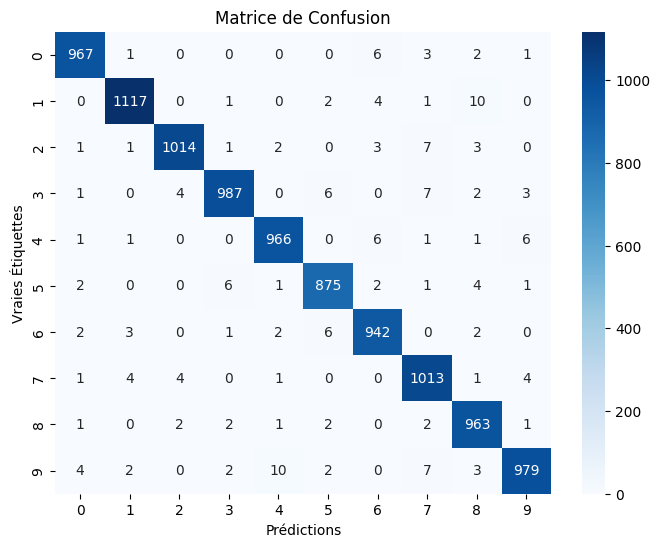

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Matrice de confusion
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies Étiquettes')
plt.show()